In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

def check_hdf5_files(base_dir, experiments, datasets):
    """
    Locate the HDF5 file in each replicate directory and display the final evolved image.

    Args:
        base_dir (str): Base directory where data is stored.
        experiments (list): List of experiment names.
        datasets (list): List of dataset names.

    Returns:
        None
    """
    all_files_present = True

    for experiment in experiments:
        for dataset in datasets:
            experiment_path = os.path.join(base_dir, experiment, dataset)
            if not os.path.exists(experiment_path):
                print(f"Path does not exist: {experiment_path}")
                all_files_present = False
                continue

            models = [m for m in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, m))]

            for model in models:
                model_path = os.path.join(experiment_path, model)
                classes = [c for c in os.listdir(model_path) if c.startswith("class_")]

                for cls in classes:
                    class_path = os.path.join(model_path, cls)
                    replicates = [r for r in os.listdir(class_path) if r.startswith("replicate_")]

                    for replicate in replicates:
                        replicate_path = os.path.join(class_path, replicate)
                        hdf5_path = os.path.join(replicate_path, "evolved_images.hdf5")

                        if not os.path.exists(hdf5_path):
                            print(f"HDF5 file missing in: {replicate_path}")
                            all_files_present = False
                        else:
                            # Read and display the final evolved image
                            with h5py.File(hdf5_path, "r") as hdf5_file:
                                if "images" in hdf5_file and hdf5_file["images"].shape[0] > 0:
                                    final_image = hdf5_file["images"][-1]
                                    plt.figure(figsize=(4, 4))
                                    plt.imshow(final_image.squeeze(), cmap="gray")
                                    plt.axis("off")
                                    plt.title(f"Final Evolved Image ({experiment} - {dataset} - {model} - {cls} - {replicate})")
                                    plt.show()
                                else:
                                    print(f"No images found in HDF5 file: {hdf5_path}")
                                    all_files_present = False

    if all_files_present:
        print("All replicates have valid HDF5 files and final images.")
    else:
        print("Some replicates are missing HDF5 files or do not contain final images.")

# Base directory and parameters
base_dir = "/media/ankit-gupta/546B-6466/data_generated"
experiments = ["Exp_1", "Exp_2_1a", "Exp_2_2"]
datasets = ["sklearnDigits"]

# Run the HDF5 file checking script
check_hdf5_files(base_dir, experiments, datasets)


In [3]:
# Function to inspect the structure of an HDF5 file
def inspect_hdf5_file(hdf5_path):
    """
    Inspect the structure and contents of an HDF5 file.

    Args:
        hdf5_path (str): Path to the HDF5 file.

    Returns:
        None
    """
    if not os.path.exists(hdf5_path):
        print(f"HDF5 file not found at: {hdf5_path}")
        return

    with h5py.File(hdf5_path, "r") as hdf5_file:
        print(f"Inspecting HDF5 file: {hdf5_path}")
        print("Keys (Datasets) in the file:")
        
        for key in hdf5_file.keys():
            dataset = hdf5_file[key]
            print(f"  - {key}: shape {dataset.shape}, dtype {dataset.dtype}")

        print("\nAttributes in the file:")
        for attr, value in hdf5_file.attrs.items():
            print(f"  - {attr}: {value}")

# Sample HDF5 file path (update if needed)
sample_hdf5_path = "/media/ankit-gupta/546B-6466/data_generated/Exp_1/sklearnDigits/SVM/class_0/replicate_1/evolved_images.hdf5"

# Run inspection on the sample HDF5 file
inspect_hdf5_file(sample_hdf5_path)


Inspecting HDF5 file: /media/ankit-gupta/546B-6466/data_generated/Exp_1/sklearnDigits/SVM/class_0/replicate_1/evolved_images.hdf5
Keys (Datasets) in the file:
  - confidence_similarity: shape (596,), dtype float32
  - confidence_target: shape (596,), dtype float32
  - final_population: shape (50, 64), dtype float32
  - fitness: shape (596,), dtype float32
  - genCount: shape (596,), dtype int32
  - images: shape (596, 8, 8), dtype float32
  - ncc_similarity: shape (596,), dtype float32
  - ncc_target: shape (596,), dtype float32
  - ssim_similarity: shape (596,), dtype float32
  - ssim_target: shape (596,), dtype float32

Attributes in the file:
  - final_genCount: 50000


HDF5 file not found: /media/ankit-gupta/546B-6466/data_generated/Exp_2_1b/sklearnDigits/CNN/target_class_3_non_target_class_5/replicate_1/evolved_images.hdf5
HDF5 file not found: /media/ankit-gupta/546B-6466/data_generated/Exp_2_1b/sklearnDigits/RNN/target_class_3_non_target_class_5/replicate_1/evolved_images.hdf5


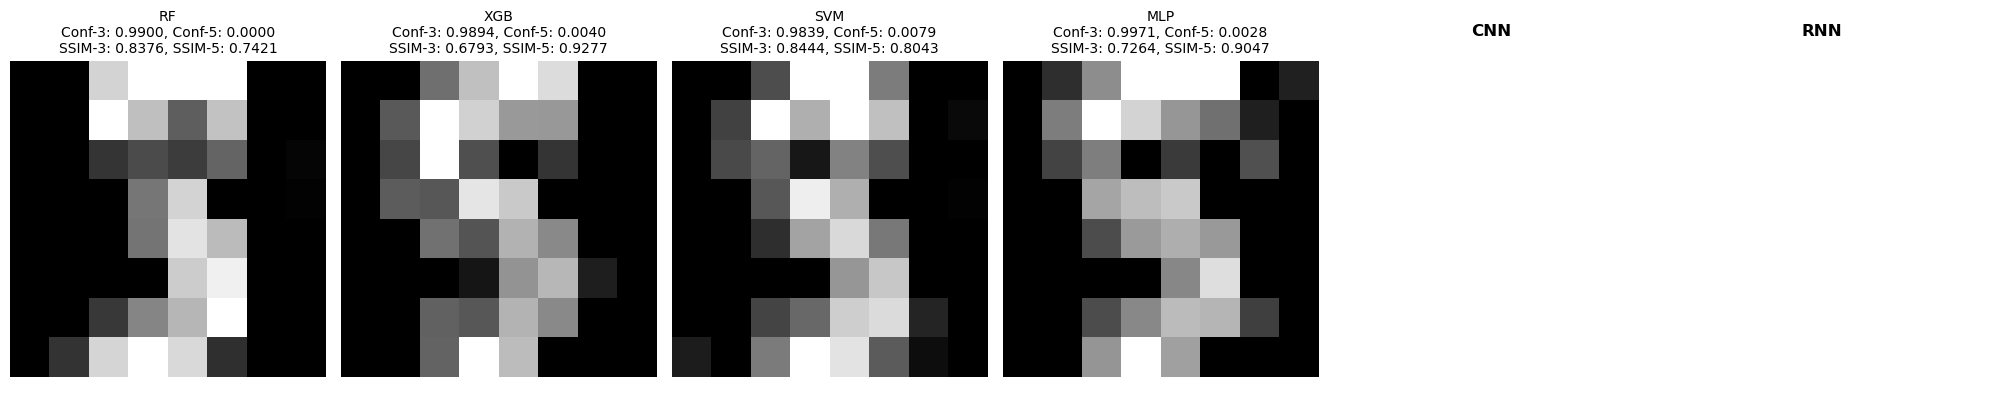

In [67]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

def get_first_class_label(base_dir, models):
    """
    Find the first available 'target_class_X_non_target_class_Y' folder alphabetically across models.
    """
    class_labels = set()
    
    for model in models:
        model_path = os.path.join(base_dir, model)
        if not os.path.exists(model_path):
            continue
        
        available_classes = [cls for cls in os.listdir(model_path) if cls.startswith("target_class_")]
        class_labels.update(available_classes)
    
    return sorted(class_labels)[5] if class_labels else None

def extract_and_plot_final_image(base_dir, models, class_label=None, replicate=1):
    """
    Extract and plot the final generation best image from replicate 1 for all models in a horizontal strip.
    """
    if class_label is None:
        class_label = get_first_class_label(base_dir, models)
        if class_label is None:
            print("No valid class labels found.")
            return
    
    # Extract target and non-target classes from the folder name
    parts = class_label.split("_")
    target_class = parts[2]  # e.g., "3" in "target_class_3_non_target_class_2"
    non_target_class = parts[-1]  # e.g., "2" in "target_class_3_non_target_class_2"

    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    
    for ax, model in zip(axes, models):
        hdf5_path = os.path.join(base_dir, model, class_label, f"replicate_{replicate}", "evolved_images.hdf5")
        
        if not os.path.exists(hdf5_path):
            print(f"HDF5 file not found: {hdf5_path}")
            ax.axis("off")
            ax.set_title(model, fontsize=12, fontweight="bold")  # Keep model labels even if missing data
            continue
        
        with h5py.File(hdf5_path, "r") as hdf5_file:
            if "images" in hdf5_file and hdf5_file["images"].shape[0] > 0:
                final_gen_index = -1  # Last generation
                final_image = hdf5_file["images"][final_gen_index]
                confidence_target = hdf5_file["confidence_target"][final_gen_index]
                confidence_non_target = hdf5_file["confidence_similarity"][final_gen_index]
                ssim_target = hdf5_file["ssim_target"][final_gen_index]
                ssim_non_target = hdf5_file["ssim_similarity"][final_gen_index]
                
                # Plot the final evolved image
                ax.imshow(final_image.squeeze(), cmap="gray")
                ax.axis("off")
                
                # Add model label above
                ax.set_title(
                    f"{model}\n"
                    f"Conf-{target_class}: {confidence_target:.4f}, Conf-{non_target_class}: {confidence_non_target:.4f}\n"
                    f"SSIM-{target_class}: {ssim_target:.4f}, SSIM-{non_target_class}: {ssim_non_target:.4f}",
                    fontsize=10
                )
            else:
                print(f"No images found in HDF5 file: {hdf5_path}")
                ax.axis("off")
                ax.set_title(model, fontsize=12, fontweight="bold")  # Keep model labels for clarity

    plt.tight_layout()
    plt.show()

# Run the extraction and visualization

# List of models to check
models = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

base_dir = "/media/ankit-gupta/546B-6466/data_generated/Exp_2_1b/sklearnDigits"

extract_and_plot_final_image(base_dir, models)


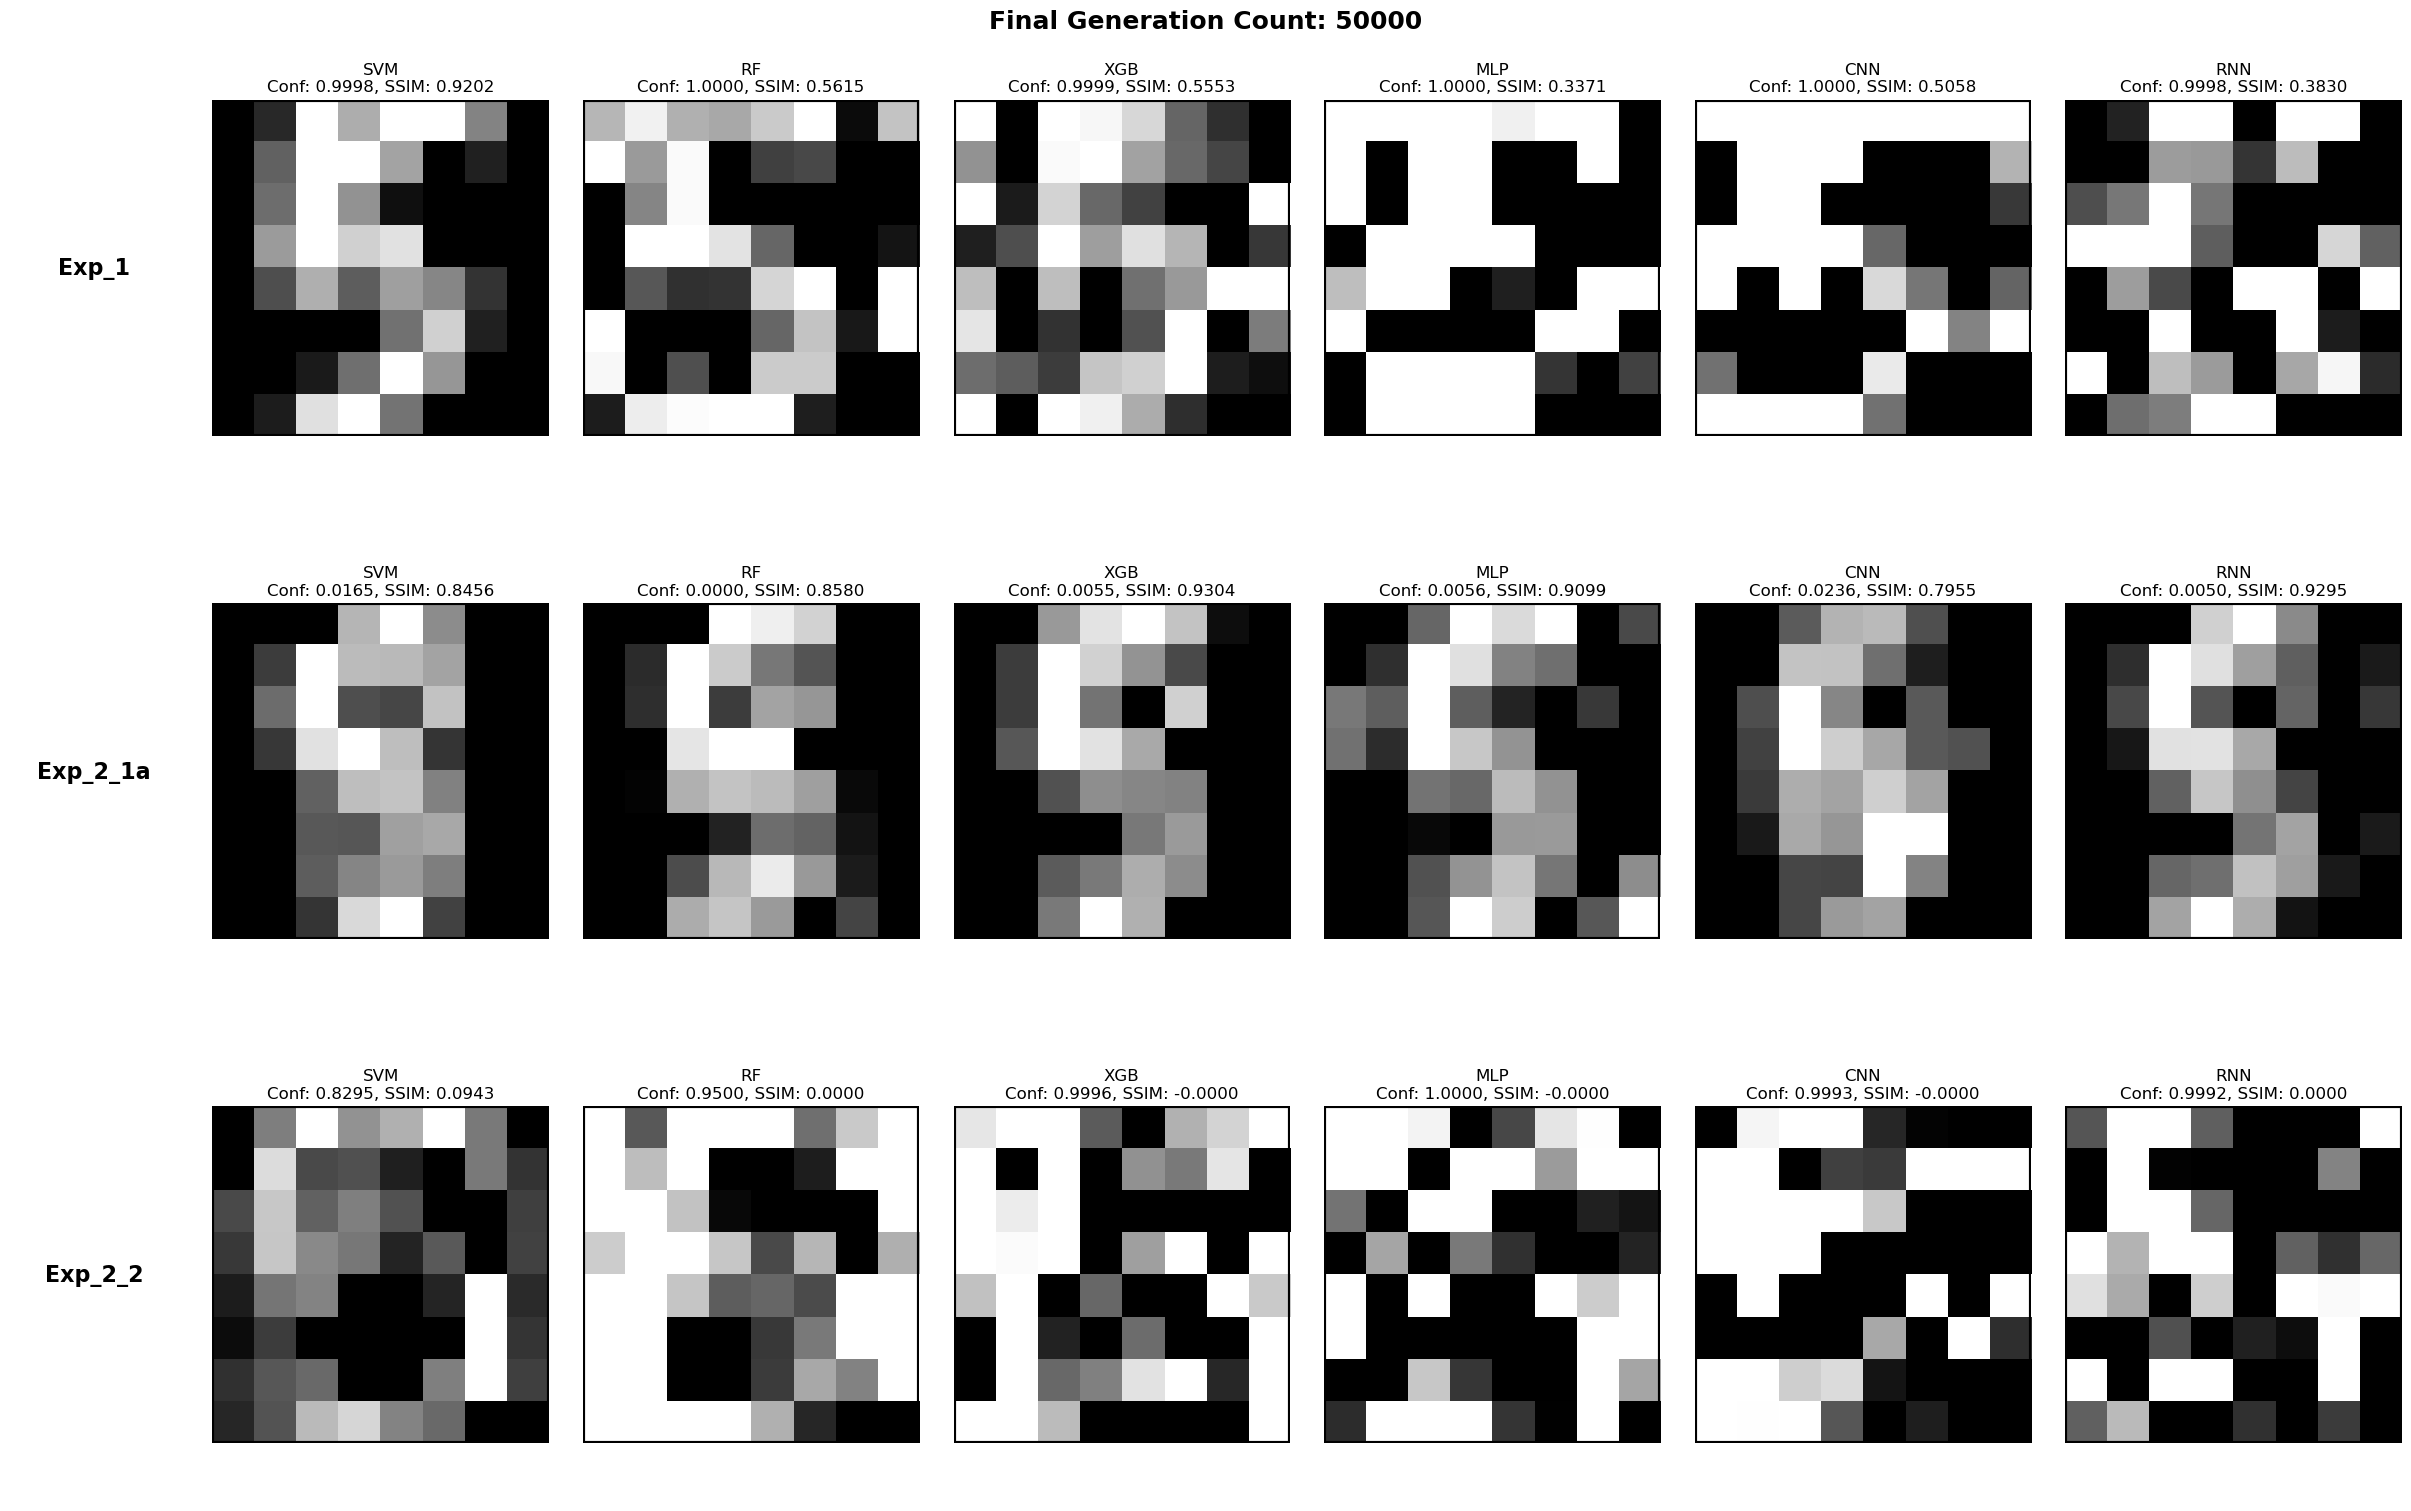

In [68]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def extract_and_plot_final_image(base_dir, experiments, models, class_label=5, replicate=1):
    """
    Extract and plot the final generation best image from replicate 1 for all models in a well-structured grid.
    """
    fig, axes = plt.subplots(len(experiments), len(models) + 1, figsize=(24, 5 * len(experiments)),
                             gridspec_kw={'width_ratios': [0.5] + [1] * len(models), 'wspace': 0.1, 'hspace': 0.1},
                             constrained_layout=True)  # Constrained layout for better spacing
    
    final_gen_count = None  # Placeholder for final generation count

    for row, experiment in enumerate(experiments):
        # Add experiment name on the left with larger text
        axes[row, 0].text(0.5, 0.5, experiment, va='center', ha='center', fontsize=16, fontweight='bold')
        axes[row, 0].axis("off")  # Hide axis for the label column

        for col, model in enumerate(models):
            ax = axes[row, col + 1] if len(experiments) > 1 else axes[col + 1]
            hdf5_path = os.path.join(base_dir, experiment, "sklearnDigits", model, f"class_{class_label}",
                                     f"replicate_{replicate}", "evolved_images.hdf5")

            if not os.path.exists(hdf5_path):
                print(f"HDF5 file not found: {hdf5_path}")
                ax.axis("off")
                continue

            with h5py.File(hdf5_path, "r") as hdf5_file:
                if "images" in hdf5_file and hdf5_file["images"].shape[0] > 0:
                    final_gen_index = -1  # Last generation
                    final_image = hdf5_file["images"][final_gen_index]
                    confidence_target = hdf5_file["confidence_target"][final_gen_index]
                    ssim_target = hdf5_file["ssim_target"][final_gen_index]
                    final_gen_count = hdf5_file.attrs.get("final_genCount", "Unknown")  # Get final_genCount

                    # Plot the final evolved image
                    ax.imshow(final_image.squeeze(), cmap="gray")
                    ax.axis("off")
                    ax.set_title(f"{model}\nConf: {confidence_target:.4f}, SSIM: {ssim_target:.4f}")

                    # Add a border grid
                    rect = patches.Rectangle((-0.5, -0.5), 8, 8, linewidth=3, edgecolor='black', facecolor='none')
                    ax.add_patch(rect)
                else:
                    print(f"No images found in HDF5 file: {hdf5_path}")
                    ax.axis("off")

    plt.suptitle(f"Final Generation Count: {final_gen_count}", fontsize=18, fontweight='bold')
    plt.show()

# Run the extraction and visualization
experiments = ["Exp_1", "Exp_2_1a", "Exp_2_2"]
models = ["SVM", "RF", "XGB", "MLP", "CNN", "RNN"]
extract_and_plot_final_image("/media/ankit-gupta/546B-6466/data_generated", experiments, models)


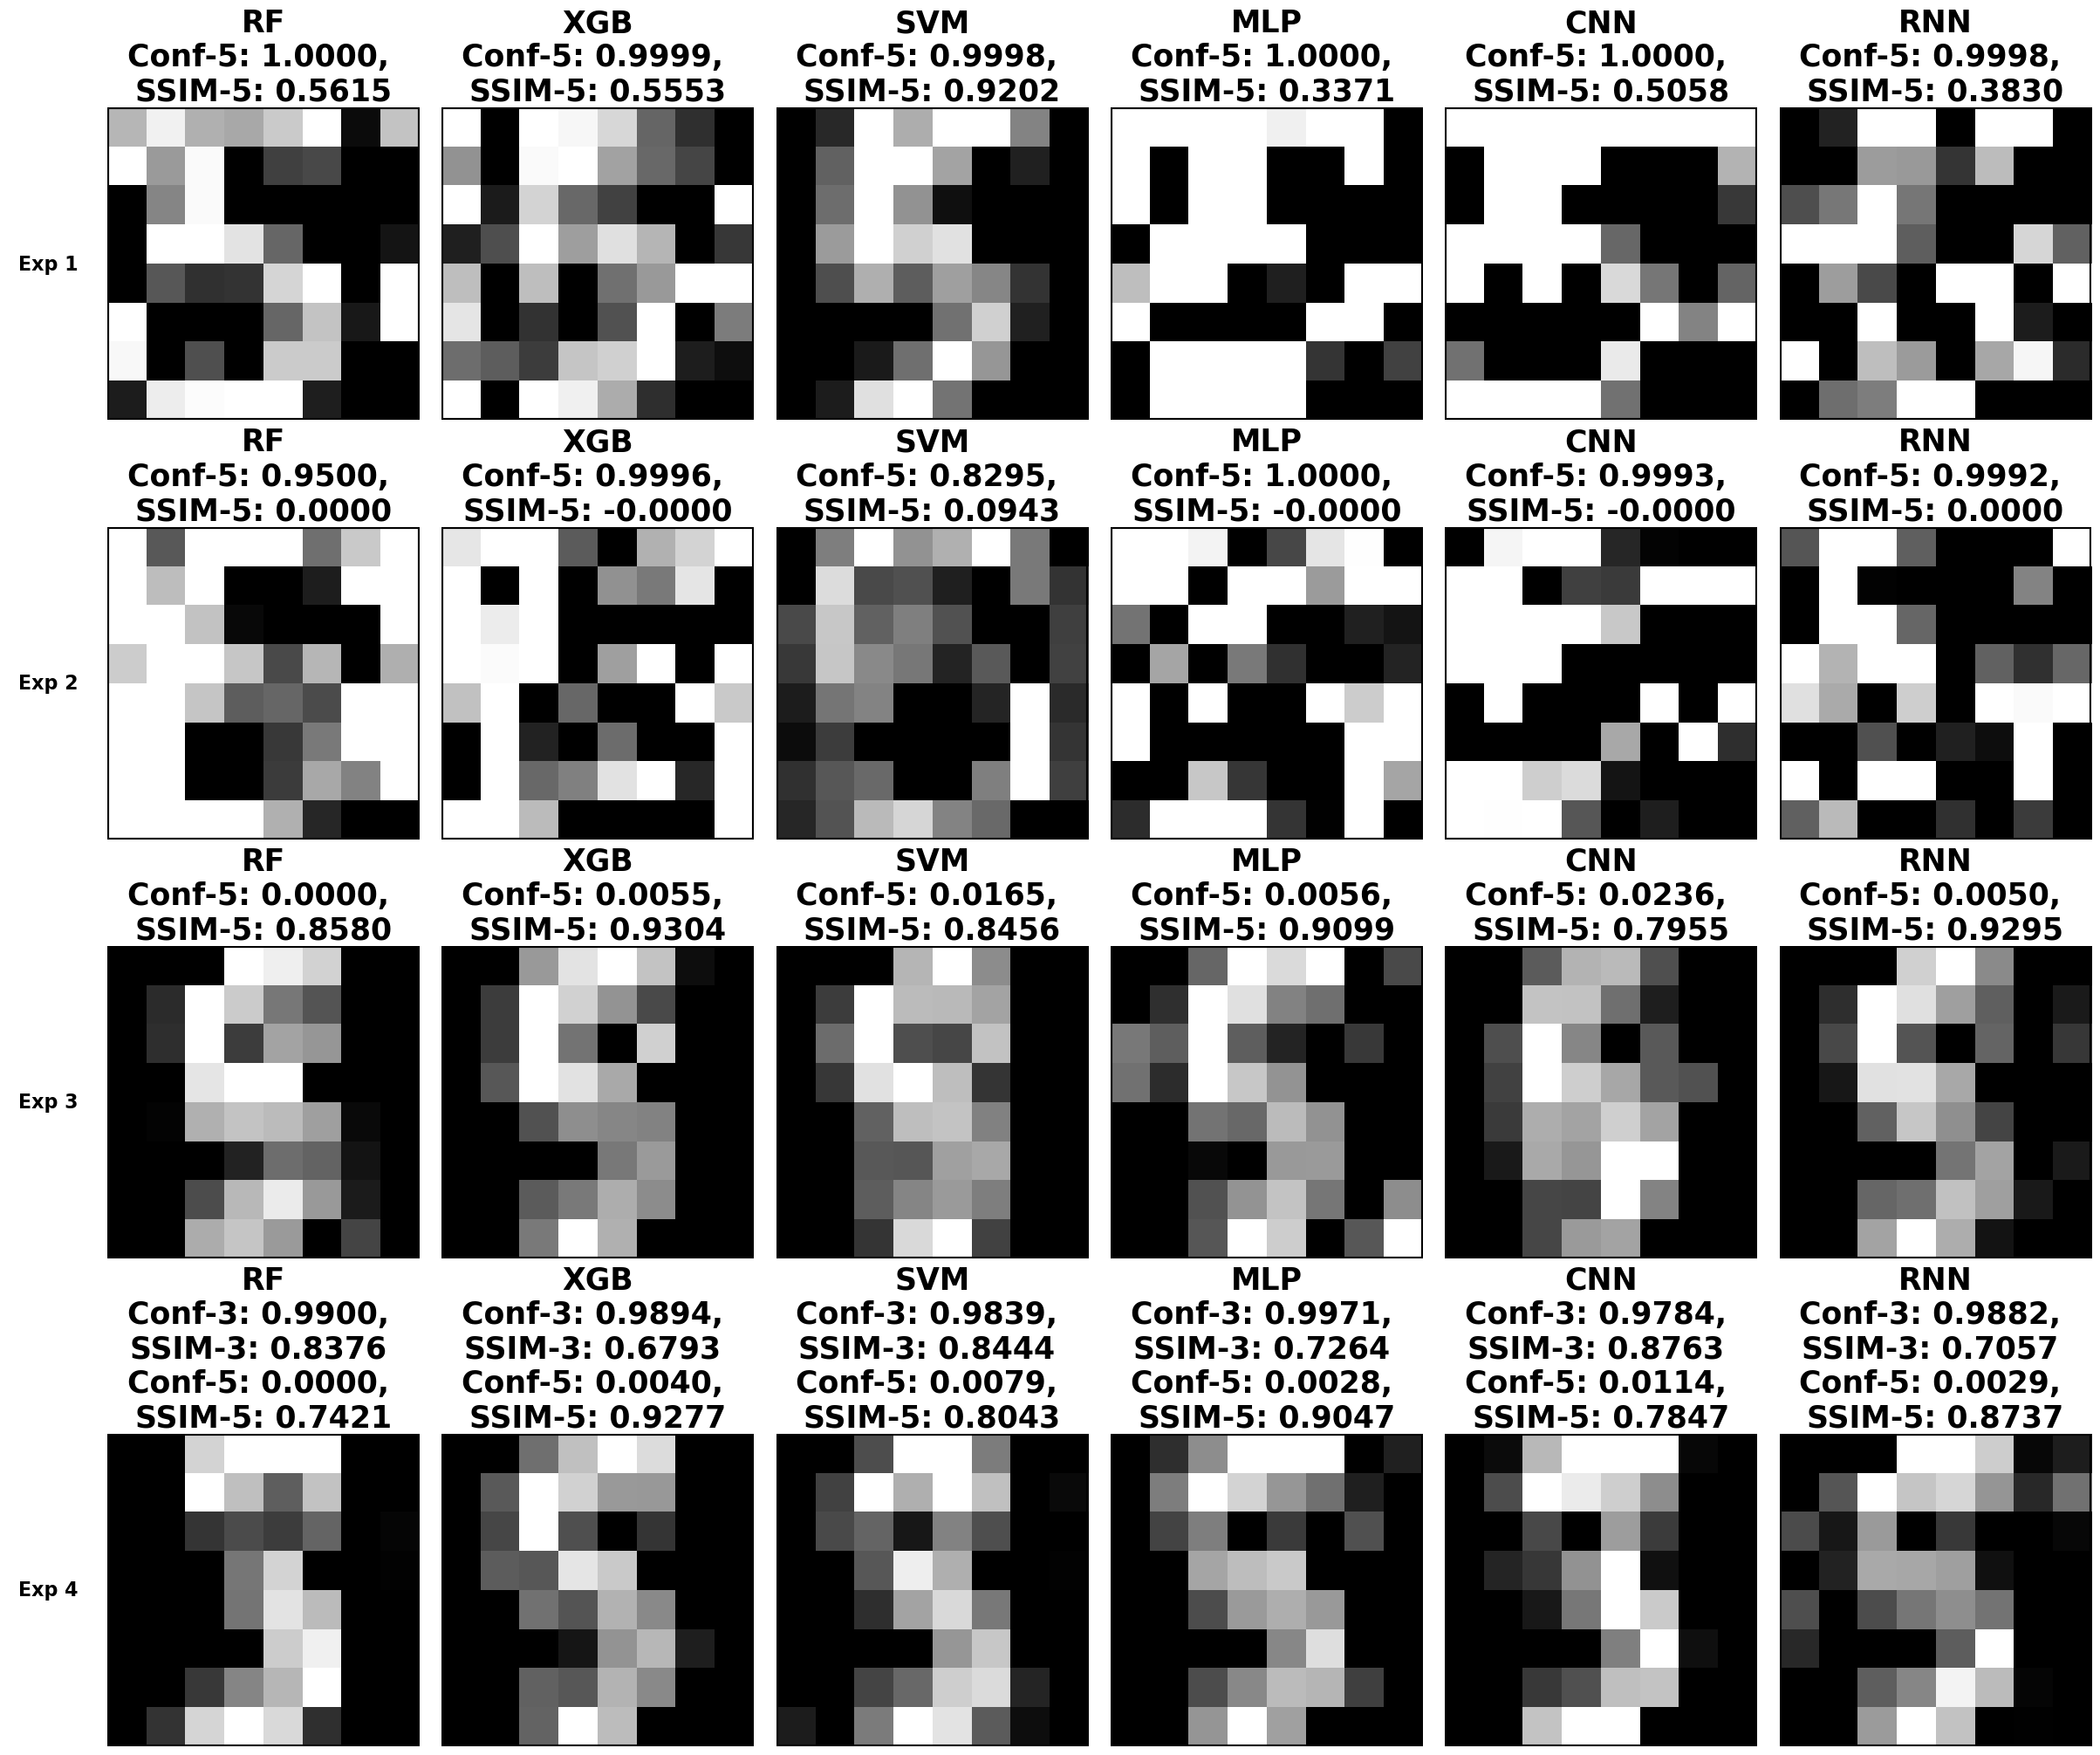

In [5]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_first_class_label(base_dir, models):
    """
    Find the first available 'target_class_X_non_target_class_Y' folder alphabetically across models.
    """
    class_labels = set()
    
    for model in models:
        model_path = os.path.join(base_dir, model)
        if not os.path.exists(model_path):
            continue
        
        available_classes = [cls for cls in os.listdir(model_path) if cls.startswith("target_class_")]
        class_labels.update(available_classes)
    
    return sorted(class_labels)[5] if class_labels else None

def extract_and_plot_final_image(base_dir, experiments, models, class_label=5, replicate=1):
    """
    Extract and plot the final generation best image from replicate 1 for all models in a well-structured grid.
    """
    experiment_aliases = {"Exp_1": "Exp 1", "Exp_2_2": "Exp 2", "Exp_2_1a": "Exp 3", "Exp_2_1b": "Exp 4"}
    
    class_label_exp_2_1b = get_first_class_label(os.path.join(base_dir, "Exp_2_1b/sklearnDigits"), models)
    if class_label_exp_2_1b is None:
        print("No valid class labels found for Exp_2_1b.")
        return
    
    # Extract target and non-target classes for 2_1b
    parts = class_label_exp_2_1b.split("_")
    target_class_2_1b = parts[2]  # Extract `X` from `target_class_X_non_target_class_Y`
    non_target_class_2_1b = parts[-1]  # Extract `Y` from `target_class_X_non_target_class_Y`
    
    # Convert to generic class_X format for first three experiments
    class_label_other_exps = f"class_{class_label}"  
    
    fig, axes = plt.subplots(len(experiments) + 1, len(models) + 1, figsize=(24, 5 * (len(experiments) + 1)),
                             gridspec_kw={'width_ratios': [0.05] + [.2] * len(models), 'wspace': 0.05, 'hspace': 0.01},
                             constrained_layout=True)
    
    final_gen_count = None  # Placeholder for final generation count

    for row, experiment in enumerate(experiments):
        exp_label = experiment_aliases.get(experiment, experiment)
        axes[row, 0].text(0.5, 0.5, exp_label, va='center', ha='center', fontsize=16, fontweight='bold')
        axes[row, 0].axis("off")

        for col, model in enumerate(models):
            ax = axes[row, col + 1]
            hdf5_path = os.path.join(base_dir, experiment, "sklearnDigits", model, class_label_other_exps,
                                     f"replicate_{replicate}", "evolved_images.hdf5")

            if not os.path.exists(hdf5_path):
                print(f"HDF5 file not found: {hdf5_path}")
                ax.axis("off")
                continue

            with h5py.File(hdf5_path, "r") as hdf5_file:
                if "images" in hdf5_file and hdf5_file["images"].shape[0] > 0:
                    final_gen_index = -1  # Last generation
                    final_image = hdf5_file["images"][final_gen_index]
                    confidence_target = hdf5_file["confidence_target"][final_gen_index]
                    ssim_target = hdf5_file["ssim_target"][final_gen_index]
                    final_gen_count = hdf5_file.attrs.get("final_genCount", "Unknown")

                    ax.imshow(final_image.squeeze(), cmap="gray")
                    ax.axis("off")
                    ax.set_title(f"{model}\nConf-{class_label}: {confidence_target:.4f}, \nSSIM-{class_label}: {ssim_target:.4f}",
                             fontsize=25, fontweight='bold')
                    rect = patches.Rectangle((-0.5, -0.5), 8, 8, linewidth=3, edgecolor='black', facecolor='none')
                    ax.add_patch(rect)
                else:
                    print(f"No images found in HDF5 file: {hdf5_path}")
                    ax.axis("off")

    # Add Exp_2_1b as the fourth row
    row = len(experiments)
    axes[row, 0].text(0.5, 0.5, experiment_aliases["Exp_2_1b"], va='center', ha='center', fontsize=16, fontweight='bold')
    axes[row, 0].axis("off")

    for col, model in enumerate(models):
        ax = axes[row, col + 1]
        hdf5_path = os.path.join(base_dir, "Exp_2_1b/sklearnDigits", model, class_label_exp_2_1b, f"replicate_{replicate}",
                                 "evolved_images.hdf5")

        if not os.path.exists(hdf5_path):
            print(f"HDF5 file not found: {hdf5_path}")
            ax.axis("off")
            continue

        with h5py.File(hdf5_path, "r") as hdf5_file:
            if "images" in hdf5_file and hdf5_file["images"].shape[0] > 0:
                final_gen_index = -1  # Last generation
                final_image = hdf5_file["images"][final_gen_index]
                confidence_target = hdf5_file["confidence_target"][final_gen_index]
                confidence_non_target = hdf5_file["confidence_similarity"][final_gen_index]
                ssim_target = hdf5_file["ssim_target"][final_gen_index]
                ssim_non_target = hdf5_file["ssim_similarity"][final_gen_index]
                final_gen_count = hdf5_file.attrs.get("final_genCount", "Unknown")

                ax.imshow(final_image.squeeze(), cmap="gray")
                ax.axis("off")
                ax.set_title(f"{model}\n"
                             f"Conf-{target_class_2_1b}: {confidence_target:.4f}, \nSSIM-{target_class_2_1b}: {ssim_target:.4f} \n"
                             f"Conf-{non_target_class_2_1b}: {confidence_non_target:.4f}, \nSSIM-{non_target_class_2_1b}: {ssim_non_target:.4f}",
                             fontsize=25, fontweight='bold')
                rect = patches.Rectangle((-0.5, -0.5), 8, 8, linewidth=3, edgecolor='black', facecolor='none')
                ax.add_patch(rect)
            else:
                print(f"No images found in HDF5 file: {hdf5_path}")
                ax.axis("off")

plt.show()


# Run the extraction and visualization
experiments = ["Exp_1", "Exp_2_2", "Exp_2_1a"]
models = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
extract_and_plot_final_image("/media/ankit-gupta/546B-6466/data_generated", experiments, models, class_label=5)

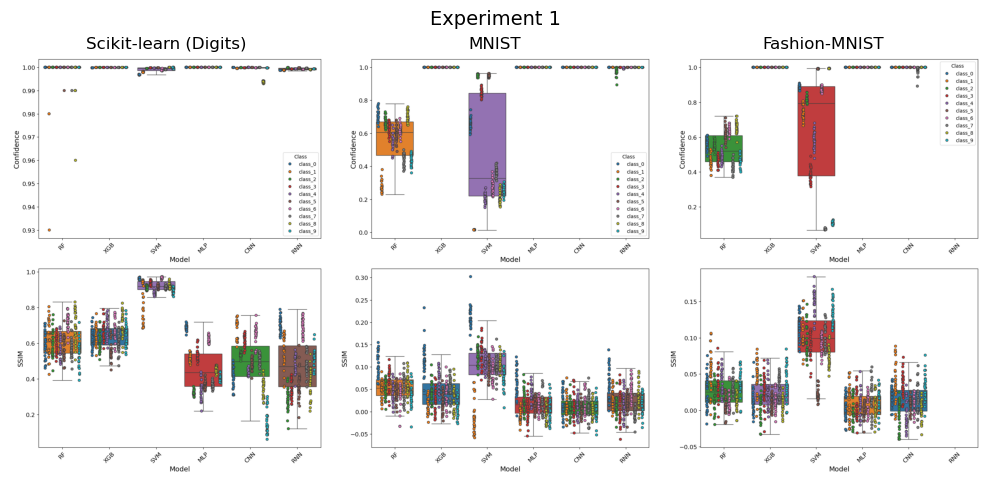

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Other Plots/"

# Load images for Experiment 1
datasets = ["skD1", "mnD1", "mnF1"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST", "Fashion-MNIST"]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 1", fontsize=14)
plt.tight_layout()

# Show in Jupyter Notebook
plt.show()


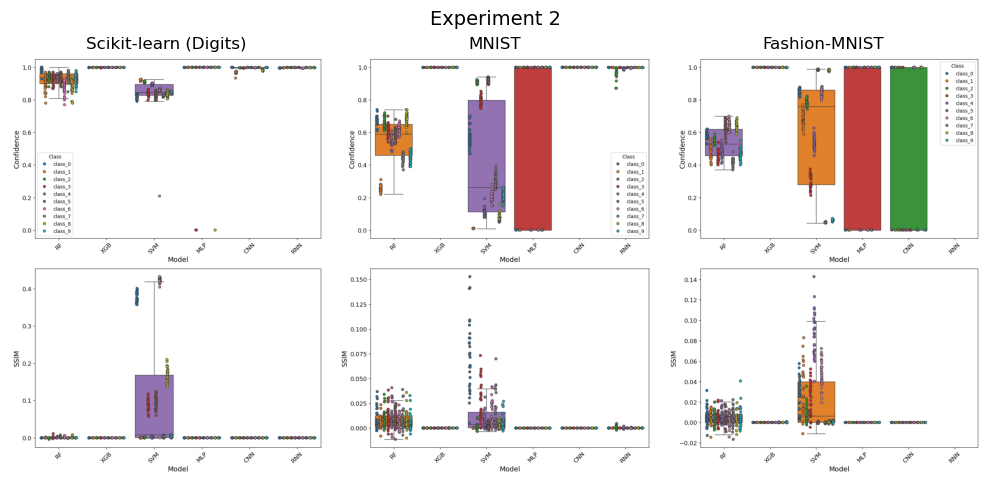

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Other Plots/"

# Load images for Experiment 1
datasets = ["skD2", "mnD2", "mnF2"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST", "Fashion-MNIST"]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 2", fontsize=14)
plt.tight_layout()

# Show in Jupyter Notebook
plt.show()


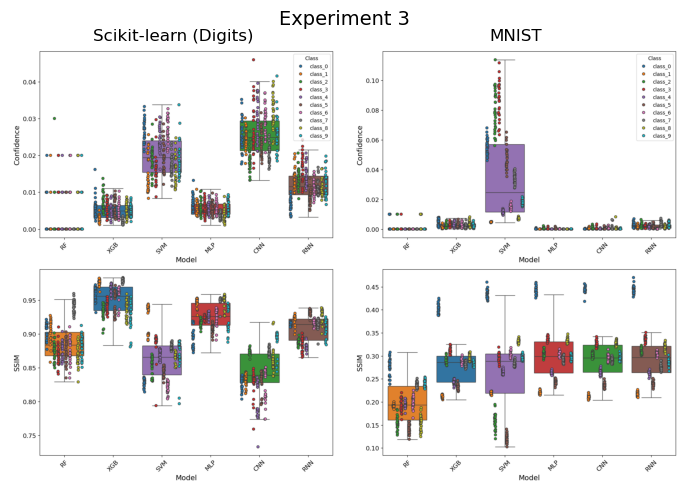

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Other Plots/"

# Load images for Experiment 1
datasets = ["skD3", "mnD3"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST"]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(7, 5))

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 3", fontsize=14)
plt.tight_layout()

# Show in Jupyter Notebook
plt.show()


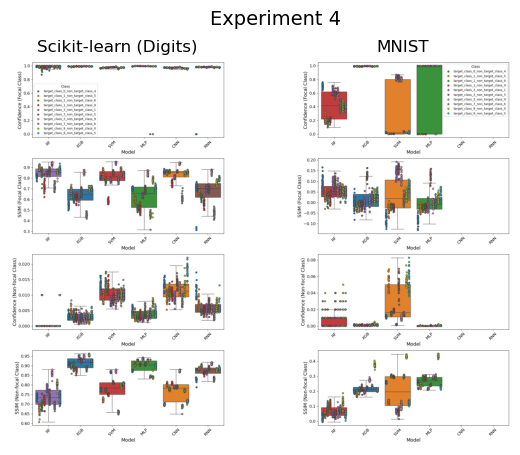

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Other Plots/"

# Load images for Experiment 4
datasets = ["skD4", "mnD4"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST"]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(6, 5))  # Reduce figure width

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 4", fontsize=14)

# Adjust spacing to push images closer
plt.subplots_adjust(wspace=0.0, left=0.0, right=0.95)  # Minimize horizontal space

# Show in Jupyter Notebook
plt.show()


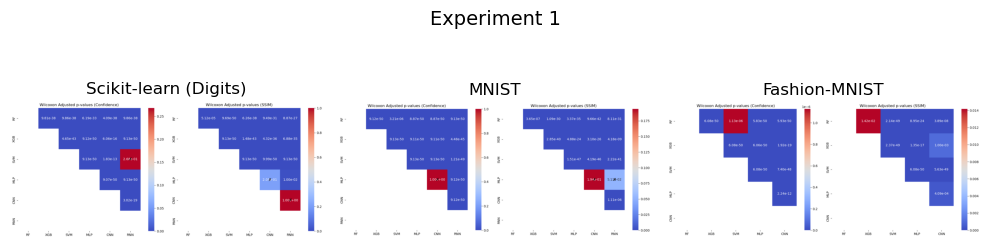

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Stats Plot/"

# Load images for Experiment 1
datasets = ["skD1", "mnD1", "mnF1"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST", "Fashion-MNIST"]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 1", fontsize=14)
plt.tight_layout()

# Show in Jupyter Notebook
plt.show()


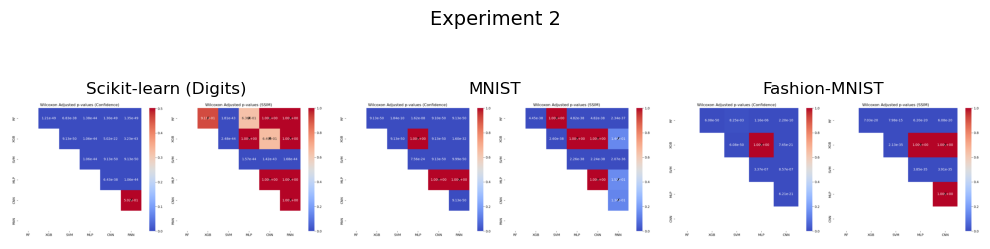

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Stats Plot/"

# Load images for Experiment 1
datasets = ["skD2", "mnD2", "mnF2"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST", "Fashion-MNIST"]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 2", fontsize=14)
plt.tight_layout()

# Show in Jupyter Notebook
plt.show()


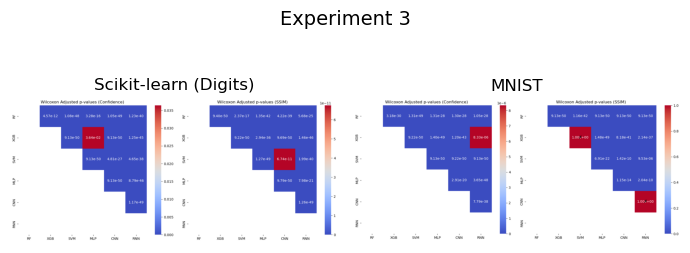

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Stats Plot/"

# Load images for Experiment 1
datasets = ["skD3", "mnD3"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST"]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 3", fontsize=14)
plt.tight_layout()

# Show in Jupyter Notebook
plt.show()


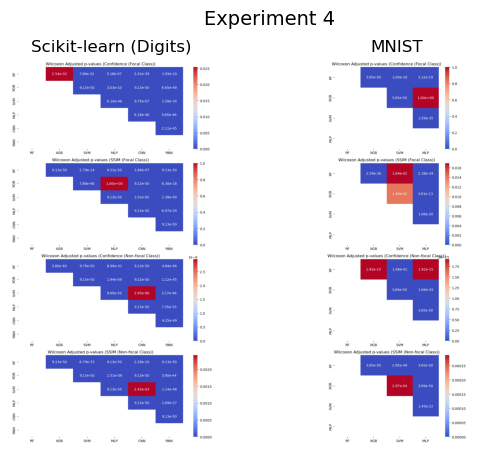

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define common path for images
image_path = "/home/ankit-gupta/Downloads/EPIC_Fool_Files/ICML Submit Files/Stats Plot/"

# Load images for Experiment 4
datasets = ["skD4", "mnD4"]  # Corresponding dataset names
titles = ["Scikit-learn (Digits)", "MNIST"]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(6, 5))  # Reduce figure width

# Display images with titles
for i, dataset in enumerate(datasets):
    img = mpimg.imread(os.path.join(image_path, f"{dataset}.png"))
    axes[i].imshow(img)
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].axis("off")

# Add title
plt.suptitle("Experiment 4", fontsize=14)

# Adjust spacing to push images closer
plt.subplots_adjust(wspace=0.0, left=0.0, right=0.95)  # Minimize horizontal space

# Show in Jupyter Notebook
plt.show()
